In [7]:
import sys
import os
!{sys.executable} -m pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [8]:
import kagglehub
import cv2
import matplotlib.pyplot as plt

In [33]:
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")
IMG_DIR = path + "/LEGO brick images v1/2357 Brick corner 1x2x2/"

In [34]:
files = os.listdir(IMG_DIR)
# list all files within IMG_DIR
files

['201706171206-0258.png',
 '201706171206-0264.png',
 '201706171206-0270.png',
 '201706171206-0099.png',
 '201706171206-0066.png',
 '201706171206-0072.png',
 '201706171206-0112.png',
 '201706171206-0106.png',
 '201706171206-0338.png',
 '201706171206-0310.png',
 '201706171206-0304.png',
 '201706171206-0305.png',
 '201706171206-0311.png',
 '201706171206-0339.png',
 '201706171206-0107.png',
 '201706171206-0113.png',
 '201706171206-0073.png',
 '201706171206-0067.png',
 '201706171206-0098.png',
 '201706171206-0271.png',
 '201706171206-0265.png',
 '201706171206-0259.png',
 '201706171206-0298.png',
 '201706171206-0273.png',
 '201706171206-0267.png',
 '201706171206-0059.png',
 '201706171206-0071.png',
 '201706171206-0065.png',
 '201706171206-0139.png',
 '201706171206-0105.png',
 '201706171206-0111.png',
 '201706171206-0307.png',
 '201706171206-0313.png',
 '201706171206-0312.png',
 '201706171206-0306.png',
 '201706171206-0110.png',
 '201706171206-0104.png',
 '201706171206-0138.png',
 '2017061712

In [106]:
def find_edges(img):
    gray_img = img
    img_blur = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray_img, (3,3), 0)
    edge_img = cv2.Canny(img,100,200)
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2BGR)
    return gray_img, img_blur, edge_img

In [111]:
img = cv2.imread("/Users/anvay-coder/scan-cv/document_2_1752701338803.jpg")
gray_img, img_blur, edge_img = find_edges(img)

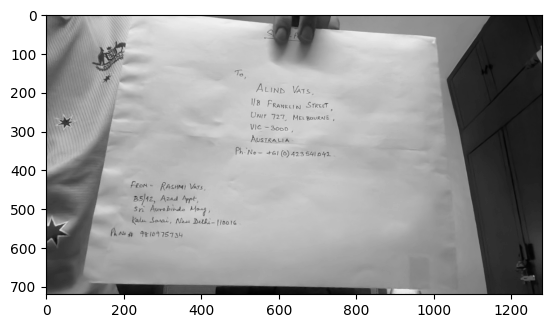

In [112]:
plt.imsave("img_gray.png", gray_img)
plt.imshow(gray_img, cmap='gray')

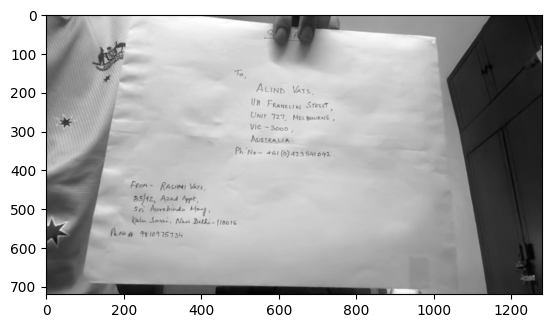

In [113]:
plt.imsave("img_blur.png", img_blur)
plt.imshow(img_blur, cmap='gray')

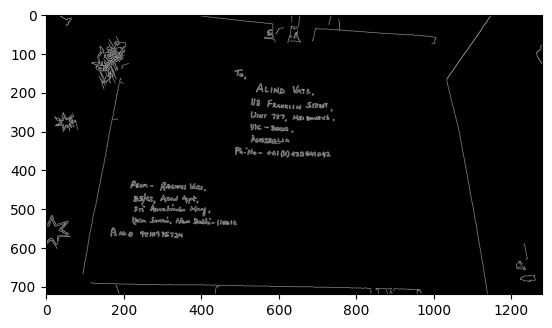

In [114]:
plt.imsave("img_edge.png", edge_img)
plt.imshow(edge_img, cmap='gray')

In [126]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def advanced_document_scanner(image, debug=False):
    """
    Scan rectangular documents using advanced edge detection and perspective correction.
    
    Args:
        image: Input color image containing a document
        debug: If True, shows intermediate processing steps
        
    Returns:
        Tuple of (original, edges_visualization, scanned_document, warped_color)
    """
    # Store original for comparison
    original = image.copy()
    
    # STEP 1: Pre-processing
    # Resize large images for faster processing
    height, width = image.shape[:2]
    max_height = 1500
    if height > max_height:
        scale = max_height / height
        image = cv2.resize(image, None, fx=scale, fy=scale)
    
    # Create a working copy
    processed = image.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
    
    # Bilateral filter preserves edges while removing noise
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # STEP 2: Multi-scale edge detection
    # Apply multiple edge detection methods and combine results
    edges = np.zeros_like(gray)
    
    # Method 1: Canny edge detection with auto threshold
    sigma = 0.33
    median_val = np.median(filtered)
    lower = int(max(0, (1.0 - sigma) * median_val))
    upper = int(min(255, (1.0 + sigma) * median_val))
    canny_edges = cv2.Canny(filtered, lower, upper)
    
    # Method 2: Adaptive thresholding
    # This helps with documents in varying lighting conditions
    thresh_adaptive = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Method 3: Sobel gradient
    grad_x = cv2.Sobel(filtered, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(filtered, cv2.CV_64F, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    sobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    _, sobel_thresh = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Combine all edge detection methods
    edges = cv2.bitwise_or(canny_edges, thresh_adaptive)
    edges = cv2.bitwise_or(edges, sobel_thresh)
    
    # Clean up edges with morphological operations
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    edges = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)
    
    # STEP 3: Find document contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    document_contour = None
    
    # Find the largest quadrilateral contour (likely our document)
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        
        # If it has 4 corners and a significant area, it's likely our document
        if len(approx) == 4 and cv2.contourArea(approx) > image.shape[0] * image.shape[1] * 0.05:
            document_contour = approx
            break
    
    # If no suitable contour found, try a more aggressive approach
    if document_contour is None:
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
            
            # Accept contours with 4-6 points (might be slightly imperfect rectangle)
            if 4 <= len(approx) <= 6 and cv2.contourArea(approx) > image.shape[0] * image.shape[1] * 0.03:
                # If more than 4 points, find the 4 extreme corners
                if len(approx) > 4:
                    rect = cv2.minAreaRect(approx)
                    document_contour = np.int32(cv2.boxPoints(rect))
                else:
                    document_contour = approx
                break
    
    # If still no contour, fall back to entire image
    if document_contour is None:
        h, w = edges.shape[:2]
        document_contour = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]]).reshape(-1, 1, 2)
    
    # STEP 4: Visualize edges and contour
    edges_visualization = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(edges_visualization, [document_contour], -1, (0, 255, 0), 2)
    
    # STEP 5: Perspective transformation
    points = document_contour.reshape(4, 2)
    
    # Order points: [top-left, top-right, bottom-right, bottom-left]
    rect = np.zeros((4, 2), dtype=np.float32)
    
    # Sum of coordinates - smallest sum is top-left, largest is bottom-right
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]  # Top-left
    rect[2] = points[np.argmax(s)]  # Bottom-right
    
    # Diff of coordinates - smallest diff is top-right, largest is bottom-left
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]  # Top-right
    rect[3] = points[np.argmax(diff)]  # Bottom-left
    
    # Calculate width and height for the new image
    width_A = np.sqrt(((rect[2][0] - rect[3][0]) ** 2) + ((rect[2][1] - rect[3][1]) ** 2))
    width_B = np.sqrt(((rect[1][0] - rect[0][0]) ** 2) + ((rect[1][1] - rect[0][1]) ** 2))
    max_width = max(int(width_A), int(width_B))
    
    height_A = np.sqrt(((rect[1][0] - rect[2][0]) ** 2) + ((rect[1][1] - rect[2][1]) ** 2))
    height_B = np.sqrt(((rect[0][0] - rect[3][0]) ** 2) + ((rect[0][1] - rect[3][1]) ** 2))
    max_height = max(int(height_A), int(height_B))
    
    # Fix aspect ratio to standard document sizes if needed
    aspect_ratio = max_width / max_height
    if 0.7 <= aspect_ratio <= 0.8:  # Close to standard letter/A4
        max_width = int(max_height * 0.75)  # 3:4 ratio
    
    # Set destination points for perspective transform
    dst_points = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype=np.float32)
    
    # Calculate perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst_points)
    
    # Warp perspective to get top-down view
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    warped_color = warped.copy()
    
    # STEP 6: Enhance the scanned document
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding for better text visibility
    # Use different block sizes for different document types
    block_sizes = [11, 15, 21]
    binarized_images = []
    for block_size in block_sizes:
        binarized = cv2.adaptiveThreshold(
            warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, block_size, 7
        )
        binarized_images.append(binarized)
    
    # Stack images to remove noise and preserve text
    final_scan = np.zeros_like(binarized_images[0])
    for img in binarized_images:
        final_scan = cv2.bitwise_or(final_scan, img)
    
    # Sharpen the document to improve text clarity
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(final_scan, -1, kernel)
    
    # Display intermediate steps if debug mode is on
    if debug:
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(2, 3, 2), plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_GRAY2RGB)), plt.title('Filtered')
        plt.subplot(2, 3, 3), plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)), plt.title('Edges')
        plt.subplot(2, 3, 4), plt.imshow(cv2.cvtColor(edges_visualization, cv2.COLOR_BGR2RGB)), plt.title('Detected Contour')
        plt.subplot(2, 3, 5), plt.imshow(cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB)), plt.title('Warped')
        plt.subplot(2, 3, 6), plt.imshow(sharpened, cmap='gray'), plt.title('Final Scan')
        plt.tight_layout()
        plt.show()
    
    return original, edges_visualization, sharpened, warped_color

# Example usage
def test_document_scanner(image_path):
    """Test the document scanner on an image"""
    # Load image
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    
    # Process image
    original, edges, scanned, warped = advanced_document_scanner(image, debug=True)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(2, 2, 2), plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)), plt.title('Detected Edges')
    plt.subplot(2, 2, 3), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)), plt.title('Color Corrected')
    plt.subplot(2, 2, 4), plt.imshow(scanned, cmap='gray'), plt.title('B&W Scan')
    plt.tight_layout()
    plt.show()
    
    return original, edges, scanned, warped

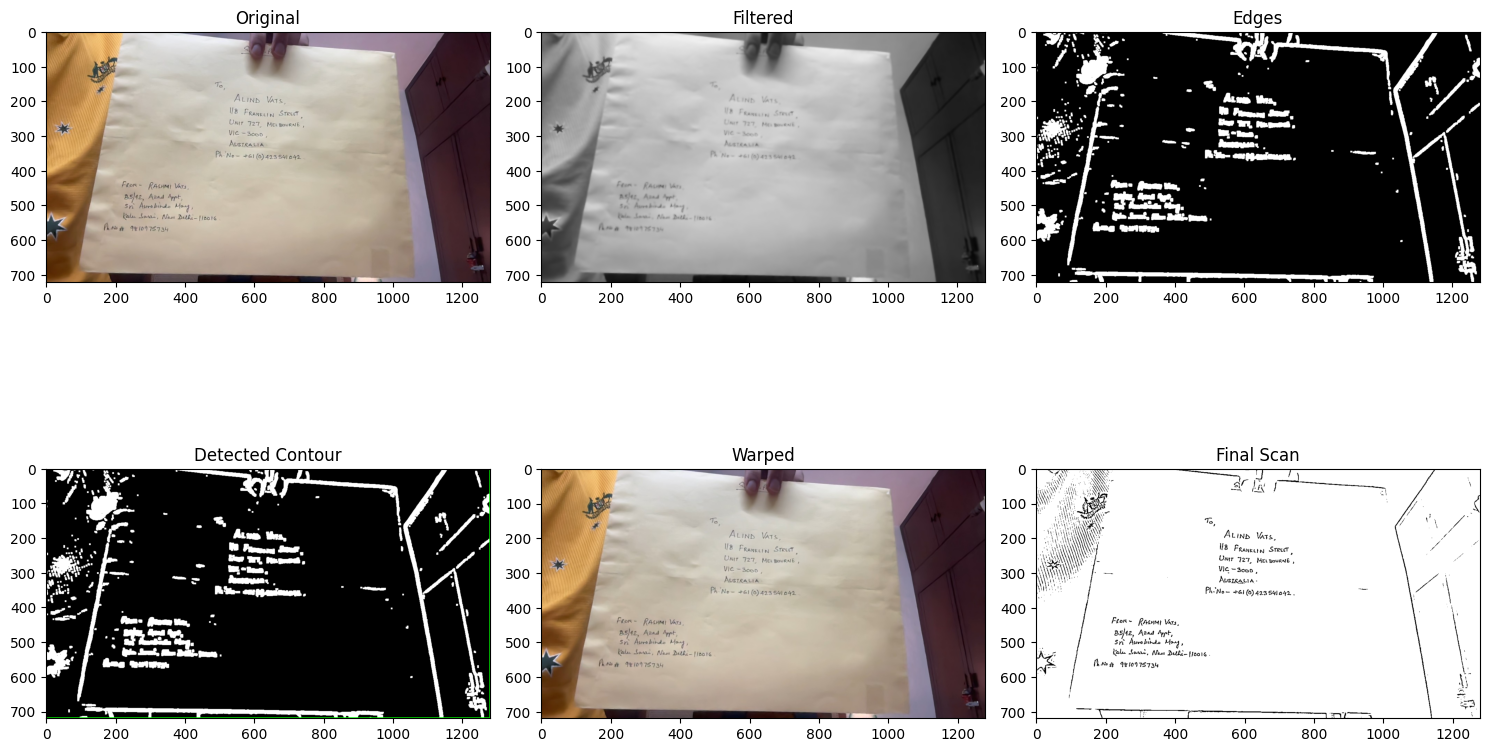

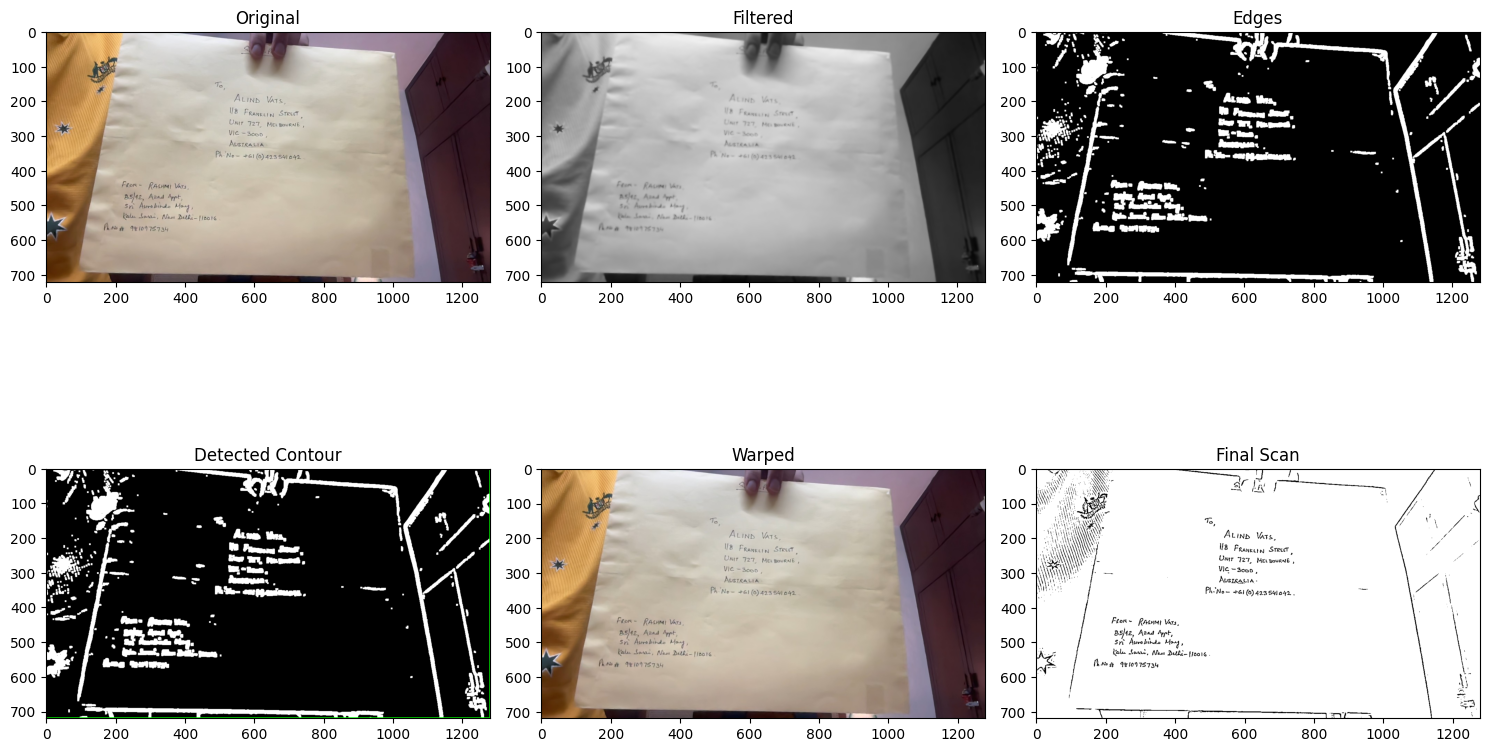

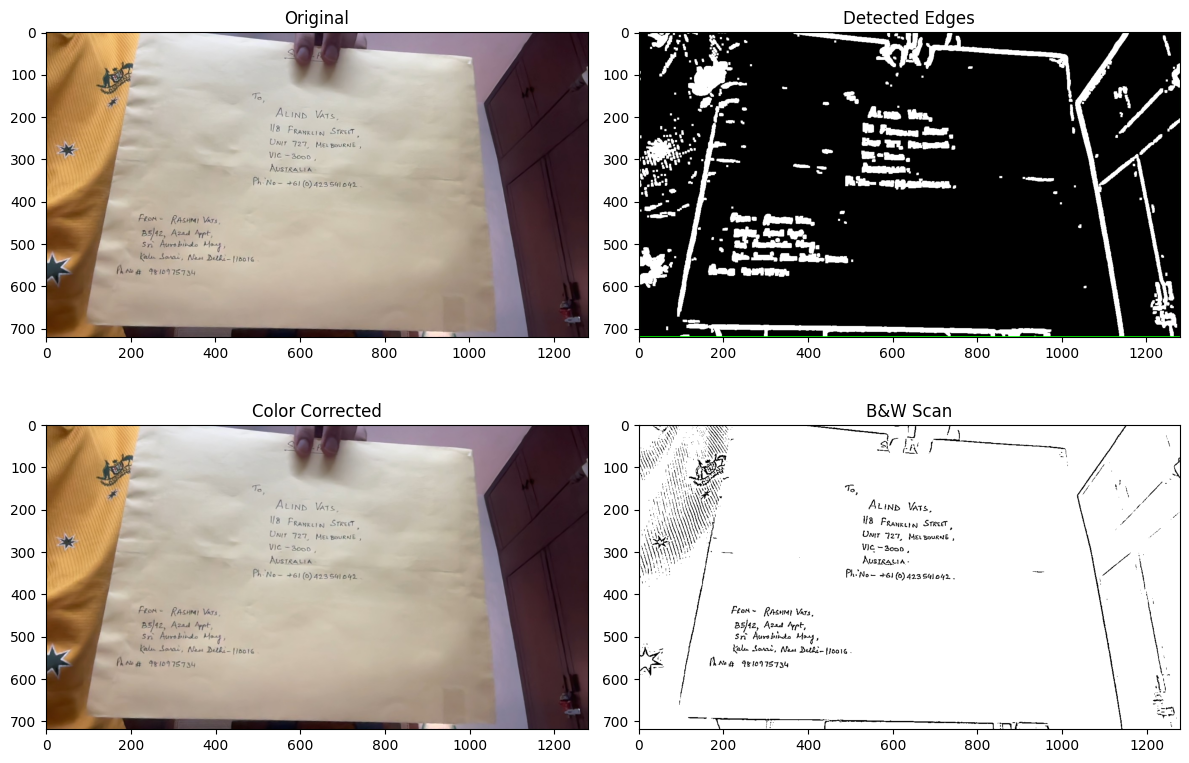

(array([[[ 41,  99, 141],
         [ 36,  94, 136],
         [ 34,  92, 134],
         ...,
         [ 29,  15,  39],
         [ 30,  16,  40],
         [ 30,  16,  40]],
 
        [[ 42, 100, 142],
         [ 36,  94, 136],
         [ 35,  93, 135],
         ...,
         [ 30,  16,  40],
         [ 30,  16,  40],
         [ 31,  17,  41]],
 
        [[ 43,  98, 141],
         [ 38,  93, 136],
         [ 36,  91, 134],
         ...,
         [ 30,  16,  40],
         [ 31,  17,  41],
         [ 31,  17,  41]],
 
        ...,
 
        [[ 31,  73, 120],
         [ 31,  73, 120],
         [ 32,  74, 121],
         ...,
         [ 32,  27,  48],
         [ 33,  28,  49],
         [ 33,  28,  49]],
 
        [[ 32,  76, 123],
         [ 32,  76, 123],
         [ 32,  76, 123],
         ...,
         [ 31,  26,  47],
         [ 32,  27,  48],
         [ 32,  27,  48]],
 
        [[ 37,  81, 128],
         [ 37,  81, 128],
         [ 38,  82, 129],
         ...,
         [ 29,  24,  45],
  

In [130]:
img_path = "/Users/anvay-coder/scan-cv/document_2_1752701338803.jpg"
original, edges, scanned, warped = advanced_document_scanner(cv2.imread(img_path), debug=True)
test_document_scanner(img_path)

In [131]:
cv2.imwrite("scanned_document.png", scanned)
cv2.imwrite("warped_document.png", warped)

True